# 학습 방법 - Scene

3개의 Scene에 대해서 각각 따로 학습

user별로 학습을 하지 않는 이유는 상관관계로 보았을 때 user끼리는 달라도 scene별로는 유사점이 꽤 보였기 때문.

In [1]:
from multiprocessing import cpu_count
from pathlib import Path
from typing import List, Union, AnyStr
from math import pi
import pickle

import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn import model_selection
from tqdm import tqdm
import torch_optimizer
from torch.utils.data import Dataset
import pandas as pd
import random

import torch_burn as tb
import utils

In [4]:
EXPERIMENT_NAME = 'Scene1-LSTM4'
CHECKPOINT_DIR = Path('checkpoint', EXPERIMENT_NAME)
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)

DATA_DIR = Path('data/1116')
TRAIN_FILES = sorted(list(DATA_DIR.glob('*scene1_0.csv')))
TEST_FILES = sorted(list(DATA_DIR.glob('*scene1_1.csv')))

# 데이터셋 생성

scene1에 대해서 모든 user의 데이터를 하나로 합친다.

In [5]:
WINDOW_SIZE = 300

In [6]:
class CSVSequentialDataset(Dataset):
    def __init__(self, csvfile,
                 window_size=300, randomized_window_size=False,
                 stride=30, randomized_stride=False):
        super(CSVSequentialDataset, self).__init__()

        self.xcols = ['input_orientation_yaw', 'input_orientation_pitch', 'input_orientation_roll',
                      'acceleration_x', 'acceleration_y', 'acceleration_z']
        self.ycols = ['input_orientation_yaw', 'input_orientation_pitch', 'input_orientation_roll']

        self.csv = pd.read_csv(csvfile)
        self.window_size = window_size

        self.indexes = []
        i = 0
        while i <= len(self.csv) - window_size * 2:
            if randomized_window_size:
                self.indexes.append((i, i + random.randint(window_size // 2, window_size)))
            else:
                self.indexes.append((i, i + window_size))

            if randomized_stride:
                i += random.randint(1, stride)
            else:
                i += stride

    def __len__(self):
        return len(self.indexes)

    def __getitem__(self, idx):
        s, t = self.indexes[idx]
        x = self.csv.iloc[s:t][self.xcols].to_numpy()
        y = self.csv.iloc[t + 6][self.ycols].to_numpy()

        x = torch.tensor(x, dtype=torch.float32) # 300, 6
        y = torch.tensor(y, dtype=torch.float32) # 3
        
        #x[:, :3] *= pi / 180
        x[:, 3:] /= 10

        return x, y

In [7]:
ds_train = [CSVSequentialDataset(f,  
                                 window_size=WINDOW_SIZE, randomized_window_size=False,
                                 stride=5, randomized_stride=True) for f in TRAIN_FILES]
ds_train = tb.data.ChainDataset(*ds_train)
ds_test = [CSVSequentialDataset(f,  
                                window_size=WINDOW_SIZE, randomized_window_size=False,
                                stride=5, randomized_stride=True) for f in TEST_FILES]
ds_test = tb.data.ChainDataset(*ds_test)

In [8]:
len(ds_train), len(ds_test)

(17286, 17944)

In [9]:
ds_train[0][0].shape, ds_train[0][1].shape

(torch.Size([300, 6]), torch.Size([3]))

In [10]:
x, y = ds_train[0]

In [11]:
x.shape

torch.Size([300, 6])

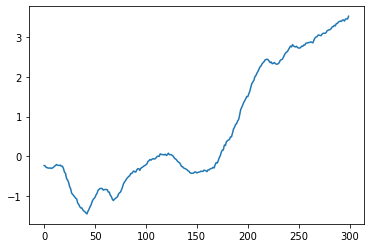

In [12]:
plt.plot(x[:, 2])

# 모델 생성

StackedLSTM Bidirectional

In [13]:
model = utils.BaselineLSTM(input_size=6,
                           hidden_size=64,
                           num_layers=8,
                           dropout=0.2,
                           bidirectional=True).cuda()

In [14]:
criterion = nn.MSELoss().cuda()
optimizer = torch_optimizer.RAdam(model.parameters())

In [15]:
metrics = [tb.metrics.ModuleMetric(criterion, 'loss'),
           utils.HPMetric('hp_metric'),
           utils.HPSignalHistory(CHECKPOINT_DIR / 'sample' / '{epoch:04d}.npy', 'hp_signal')]

In [16]:
callbacks = [tb.callbacks.EarlyStopping(metrics[0]),
             tb.callbacks.LRDecaying(optimizer, metrics[0])]

In [17]:
trainer = tb.Trainer(model, optimizer, metrics, callbacks, ncols=100)

In [18]:
trainer.fit(ds_train, ds_test, num_epochs=100, batch_size=256, shuffle=True, pin_memory=True)

[0002/0100] Train:   0%|                                                     | 0/68 [00:00<?, ?it/s]

                  validation
 - Yaw          :   9.555084
 - Pitch        :  12.343380
 - Roll         :   3.076116
 - RMS          :   9.185516
 - 99% Tile     :  43.253641
Save output signals into checkpoint/Scene1-LSTM4/sample/0001.npy


[0003/0100] Train:   0%|                                                     | 0/68 [00:00<?, ?it/s]

                  validation
 - Yaw          :   8.998699
 - Pitch        :   9.334251
 - Roll         :   3.074179
 - RMS          :   7.693188
 - 99% Tile     :  40.711262
Save output signals into checkpoint/Scene1-LSTM4/sample/0002.npy


[0004/0100] Train:   0%|                                                     | 0/68 [00:00<?, ?it/s]

                  validation
 - Yaw          :   8.907434
 - Pitch        :   7.695905
 - Roll         :   3.025908
 - RMS          :   7.017251
 - 99% Tile     :  38.498202
Save output signals into checkpoint/Scene1-LSTM4/sample/0003.npy


[0005/0100] Train:   0%|                                                     | 0/68 [00:00<?, ?it/s]

                  validation
 - Yaw          :   6.197730
 - Pitch        :   6.799731
 - Roll         :   2.991490
 - RMS          :   5.585613
 - 99% Tile     :  34.255402
Save output signals into checkpoint/Scene1-LSTM4/sample/0004.npy


[0006/0100] Train:   0%|                                                     | 0/68 [00:00<?, ?it/s]

                  validation
 - Yaw          :   5.111112
 - Pitch        :   5.277298
 - Roll         :   2.979436
 - RMS          :   4.577131
 - 99% Tile     :  31.848024
Save output signals into checkpoint/Scene1-LSTM4/sample/0005.npy


[0007/0100] Train:   0%|                                                     | 0/68 [00:00<?, ?it/s]

                  validation
 - Yaw          :   4.388671
 - Pitch        :   4.292875
 - Roll         :   2.911832
 - RMS          :   3.922923
 - 99% Tile     :  28.883767
Save output signals into checkpoint/Scene1-LSTM4/sample/0006.npy


[0008/0100] Train:   0%|                                                     | 0/68 [00:00<?, ?it/s]

                  validation
 - Yaw          :   3.621289
 - Pitch        :   3.447184
 - Roll         :   2.900119
 - RMS          :   3.337040
 - 99% Tile     :  26.474662
Save output signals into checkpoint/Scene1-LSTM4/sample/0007.npy


[0009/0100] Train:   0%|                                                     | 0/68 [00:00<?, ?it/s]

                  validation
 - Yaw          :   3.021711
 - Pitch        :   3.167988
 - Roll         :   2.899123
 - RMS          :   3.031600
 - 99% Tile     :  24.404422
Save output signals into checkpoint/Scene1-LSTM4/sample/0008.npy


[0010/0100] Train:   0%|                                                     | 0/68 [00:00<?, ?it/s]

                  validation
 - Yaw          :   3.193064
 - Pitch        :   2.807170
 - Roll         :   2.838178
 - RMS          :   2.951334
 - 99% Tile     :  23.106900
Save output signals into checkpoint/Scene1-LSTM4/sample/0009.npy


[0011/0100] Train:   0%|                                                     | 0/68 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.452052
 - Pitch        :   2.426284
 - Roll         :   2.885430
 - RMS          :   2.596479
 - 99% Tile     :  21.618600
Save output signals into checkpoint/Scene1-LSTM4/sample/0010.npy


[0012/0100] Train:   0%|                                                     | 0/68 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.341497
 - Pitch        :   2.277691
 - Roll         :   2.871434
 - RMS          :   2.511017
 - 99% Tile     :  20.478336
Save output signals into checkpoint/Scene1-LSTM4/sample/0011.npy


[0013/0100] Train:   0%|                                                     | 0/68 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.582007
 - Pitch        :   2.055724
 - Roll         :   2.793756
 - RMS          :   2.496520
 - 99% Tile     :  19.460552
Save output signals into checkpoint/Scene1-LSTM4/sample/0012.npy


[0014/0100] Train:   0%|                                                     | 0/68 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.965800
 - Pitch        :   2.029507
 - Roll         :   2.682616
 - RMS          :   2.249422
 - 99% Tile     :  18.808183
Save output signals into checkpoint/Scene1-LSTM4/sample/0013.npy


[0015/0100] Train:   0%|                                                     | 0/68 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.231725
 - Pitch        :   2.105660
 - Roll         :   2.608688
 - RMS          :   2.325199
 - 99% Tile     :  17.812693
Save output signals into checkpoint/Scene1-LSTM4/sample/0014.npy


[0016/0100] Train:   0%|                                                     | 0/68 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.680523
 - Pitch        :   1.839623
 - Roll         :   2.246248
 - RMS          :   1.936836
 - 99% Tile     :  17.155512
Save output signals into checkpoint/Scene1-LSTM4/sample/0015.npy


[0017/0100] Train:   0%|                                                     | 0/68 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.593188
 - Pitch        :   2.013745
 - Roll         :   2.142298
 - RMS          :   1.930704
 - 99% Tile     :  16.653086
Save output signals into checkpoint/Scene1-LSTM4/sample/0016.npy


[0018/0100] Train:   0%|                                                     | 0/68 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.656855
 - Pitch        :   1.966329
 - Roll         :   2.044657
 - RMS          :   1.896685
 - 99% Tile     :  16.334293
Save output signals into checkpoint/Scene1-LSTM4/sample/0017.npy


[0019/0100] Train:   0%|                                                     | 0/68 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.509631
 - Pitch        :   1.899895
 - Roll         :   1.949755
 - RMS          :   1.797232
 - 99% Tile     :  15.078813
Save output signals into checkpoint/Scene1-LSTM4/sample/0018.npy


[0020/0100] Train:   0%|                                                     | 0/68 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.706850
 - Pitch        :   1.682470
 - Roll         :   1.894736
 - RMS          :   1.763903
 - 99% Tile     :  15.385703
Save output signals into checkpoint/Scene1-LSTM4/sample/0019.npy


[0021/0100] Train:   0%|                                                     | 0/68 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.563462
 - Pitch        :   1.607275
 - Roll         :   1.826864
 - RMS          :   1.669848
 - 99% Tile     :  14.713656
Save output signals into checkpoint/Scene1-LSTM4/sample/0020.npy


[0022/0100] Train:   0%|                                                     | 0/68 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   2.003707
 - Pitch        :   1.747464
 - Roll         :   1.786206
 - RMS          :   1.849234
 - 99% Tile     :  14.348084
Save output signals into checkpoint/Scene1-LSTM4/sample/0021.npy


[0023/0100] Train:   0%|                                                     | 0/68 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.733453
 - Pitch        :   1.708570
 - Roll         :   1.738440
 - RMS          :   1.726871
 - 99% Tile     :  14.368463
Save output signals into checkpoint/Scene1-LSTM4/sample/0022.npy


[0024/0100] Train:   0%|                                                     | 0/68 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.578588
 - Pitch        :   1.437154
 - Roll         :   1.620349
 - RMS          :   1.547351
 - 99% Tile     :  14.194722
Save output signals into checkpoint/Scene1-LSTM4/sample/0023.npy


[0025/0100] Train:   0%|                                                     | 0/68 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.492576
 - Pitch        :   1.441442
 - Roll         :   1.647358
 - RMS          :   1.529632
 - 99% Tile     :  13.661090
Save output signals into checkpoint/Scene1-LSTM4/sample/0024.npy


[0026/0100] Train:   0%|                                                     | 0/68 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.358807
 - Pitch        :   1.536274
 - Roll         :   1.578518
 - RMS          :   1.494235
 - 99% Tile     :  14.612156
Save output signals into checkpoint/Scene1-LSTM4/sample/0025.npy


[0027/0100] Train:   0%|                                                     | 0/68 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.435065
 - Pitch        :   1.422460
 - Roll         :   1.542891
 - RMS          :   1.467801
 - 99% Tile     :  13.844929
Save output signals into checkpoint/Scene1-LSTM4/sample/0026.npy


[0028/0100] Train:   0%|                                                     | 0/68 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.118491
 - Pitch        :   1.353261
 - Roll         :   1.527702
 - RMS          :   1.343653
 - 99% Tile     :  14.555186
Save output signals into checkpoint/Scene1-LSTM4/sample/0027.npy


[0029/0100] Train:   0%|                                                     | 0/68 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.709880
 - Pitch        :   1.361568
 - Roll         :   1.592891
 - RMS          :   1.561501
 - 99% Tile     :  13.731657
Save output signals into checkpoint/Scene1-LSTM4/sample/0028.npy


[0030/0100] Train:   0%|                                                     | 0/68 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.698493
 - Pitch        :   1.436095
 - Roll         :   1.528286
 - RMS          :   1.558087
 - 99% Tile     :  14.208571
Save output signals into checkpoint/Scene1-LSTM4/sample/0029.npy


[0031/0100] Train:   0%|                                                     | 0/68 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.223894
 - Pitch        :   1.288292
 - Roll         :   1.460319
 - RMS          :   1.327924
 - 99% Tile     :  14.467308
Save output signals into checkpoint/Scene1-LSTM4/sample/0030.npy


[0032/0100] Train:   0%|                                                     | 0/68 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.130112
 - Pitch        :   1.308737
 - Roll         :   1.503853
 - RMS          :   1.323067
 - 99% Tile     :  14.778386
Save output signals into checkpoint/Scene1-LSTM4/sample/0031.npy


[0033/0100] Train:   0%|                                                     | 0/68 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.365441
 - Pitch        :   1.656535
 - Roll         :   1.421938
 - RMS          :   1.486657
 - 99% Tile     :  14.023732
Save output signals into checkpoint/Scene1-LSTM4/sample/0032.npy


[0034/0100] Train:   0%|                                                     | 0/68 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.529331
 - Pitch        :   1.538579
 - Roll         :   1.448928
 - RMS          :   1.506151
 - 99% Tile     :  13.970671
Save output signals into checkpoint/Scene1-LSTM4/sample/0033.npy


[0035/0100] Train:   0%|                                                     | 0/68 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.129034
 - Pitch        :   1.296911
 - Roll         :   1.406951
 - RMS          :   1.282732
 - 99% Tile     :  13.861277
Save output signals into checkpoint/Scene1-LSTM4/sample/0034.npy


[0036/0100] Train:   0%|                                                     | 0/68 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.196233
 - Pitch        :   1.234609
 - Roll         :   1.467222
 - RMS          :   1.304860
 - 99% Tile     :  13.823963
Save output signals into checkpoint/Scene1-LSTM4/sample/0035.npy


[0037/0100] Train:   0%|                                                     | 0/68 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.650220
 - Pitch        :   1.353583
 - Roll         :   1.491258
 - RMS          :   1.503248
 - 99% Tile     :  14.004180
Save output signals into checkpoint/Scene1-LSTM4/sample/0036.npy


[0038/0100] Train:   0%|                                                     | 0/68 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.374421
 - Pitch        :   1.386048
 - Roll         :   1.293845
 - RMS          :   1.352060
 - 99% Tile     :  13.882676
Save output signals into checkpoint/Scene1-LSTM4/sample/0037.npy


[0039/0100] Train:   0%|                                                     | 0/68 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   1.181585
 - Pitch        :   1.355883
 - Roll         :   1.426500
 - RMS          :   1.325326
 - 99% Tile     :  13.652902
Save output signals into checkpoint/Scene1-LSTM4/sample/0038.npy


[0040/0100] Train:   0%|                                                     | 0/68 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.121182
 - Pitch        :   1.397153
 - Roll         :   1.248368
 - RMS          :   1.260623
 - 99% Tile     :  13.671172
Save output signals into checkpoint/Scene1-LSTM4/sample/0039.npy


[0041/0100] Train:   0%|                                                     | 0/68 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.108140
 - Pitch        :   1.434701
 - Roll         :   1.322023
 - RMS          :   1.295388
 - 99% Tile     :  14.133078
Save output signals into checkpoint/Scene1-LSTM4/sample/0040.npy


[0042/0100] Train:   0%|                                                     | 0/68 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.086707
 - Pitch        :   1.221954
 - Roll         :   1.208914
 - RMS          :   1.174106
 - 99% Tile     :  13.563737
Save output signals into checkpoint/Scene1-LSTM4/sample/0041.npy


[0043/0100] Train:   0%|                                                     | 0/68 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.271856
 - Pitch        :   1.440653
 - Roll         :   1.216814
 - RMS          :   1.313232
 - 99% Tile     :  13.650463
Save output signals into checkpoint/Scene1-LSTM4/sample/0042.npy


[0044/0100] Train:   0%|                                                     | 0/68 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.034811
 - Pitch        :   1.265074
 - Roll         :   1.314245
 - RMS          :   1.210852
 - 99% Tile     :  13.600126
Save output signals into checkpoint/Scene1-LSTM4/sample/0043.npy


[0045/0100] Train:   0%|                                                     | 0/68 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.061626
 - Pitch        :   1.403986
 - Roll         :   1.241519
 - RMS          :   1.243596
 - 99% Tile     :  12.825870
Save output signals into checkpoint/Scene1-LSTM4/sample/0044.npy


[0046/0100] Train:   0%|                                                     | 0/68 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.062240
 - Pitch        :   1.229528
 - Roll         :   1.196741
 - RMS          :   1.165087
 - 99% Tile     :  13.304275
Save output signals into checkpoint/Scene1-LSTM4/sample/0045.npy


[0047/0100] Train:   0%|                                                     | 0/68 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.154173
 - Pitch        :   1.292539
 - Roll         :   1.183111
 - RMS          :   1.211408
 - 99% Tile     :  13.441555
Save output signals into checkpoint/Scene1-LSTM4/sample/0046.npy


[0048/0100] Train:   0%|                                                     | 0/68 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   1.172397
 - Pitch        :   1.235055
 - Roll         :   1.166580
 - RMS          :   1.191747
 - 99% Tile     :  12.952722
Save output signals into checkpoint/Scene1-LSTM4/sample/0047.npy


[0049/0100] Train:   0%|                                                     | 0/68 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   1.050910
 - Pitch        :   1.208245
 - Roll         :   1.173095
 - RMS          :   1.146069
 - 99% Tile     :  13.334414
Save output signals into checkpoint/Scene1-LSTM4/sample/0048.npy


[0050/0100] Train:   0%|                                                     | 0/68 [00:00<?, ?it/s]

Decaying lr from 0.001 to 0.0005 because val_loss did not improved for 5 epochs
val_loss is not improved for 5 epochs
                  validation
 - Yaw          :   1.393980
 - Pitch        :   1.330218
 - Roll         :   1.222642
 - RMS          :   1.317512
 - 99% Tile     :  13.003977
Save output signals into checkpoint/Scene1-LSTM4/sample/0049.npy


[0051/0100] Train:   0%|                                                     | 0/68 [00:00<?, ?it/s]

val_loss is not improved for 6 epochs
                  validation
 - Yaw          :   0.972717
 - Pitch        :   1.130665
 - Roll         :   1.243566
 - RMS          :   1.121166
 - 99% Tile     :  13.642253
Save output signals into checkpoint/Scene1-LSTM4/sample/0050.npy


[0052/0100] Train:   0%|                                                     | 0/68 [00:00<?, ?it/s]

val_loss is not improved for 7 epochs
                  validation
 - Yaw          :   1.123089
 - Pitch        :   1.129151
 - Roll         :   1.231950
 - RMS          :   1.162470
 - 99% Tile     :  13.360095
Save output signals into checkpoint/Scene1-LSTM4/sample/0051.npy


[0053/0100] Train:   0%|                                                     | 0/68 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.958945
 - Pitch        :   1.090774
 - Roll         :   1.207527
 - RMS          :   1.090487
 - 99% Tile     :  13.416411
Save output signals into checkpoint/Scene1-LSTM4/sample/0052.npy


[0054/0100] Train:   0%|                                                     | 0/68 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.988797
 - Pitch        :   1.120103
 - Roll         :   1.133259
 - RMS          :   1.082686
 - 99% Tile     :  13.011492
Save output signals into checkpoint/Scene1-LSTM4/sample/0053.npy


[0055/0100] Train:   0%|                                                     | 0/68 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.050251
 - Pitch        :   1.115363
 - Roll         :   1.118360
 - RMS          :   1.095109
 - 99% Tile     :  12.937068
Save output signals into checkpoint/Scene1-LSTM4/sample/0054.npy


[0056/0100] Train:   0%|                                                     | 0/68 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   0.951410
 - Pitch        :   1.116605
 - Roll         :   1.136241
 - RMS          :   1.071297
 - 99% Tile     :  13.208341
Save output signals into checkpoint/Scene1-LSTM4/sample/0055.npy


[0057/0100] Train:   0%|                                                     | 0/68 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   0.891558
 - Pitch        :   1.212568
 - Roll         :   1.132407
 - RMS          :   1.087435
 - 99% Tile     :  13.048061
Save output signals into checkpoint/Scene1-LSTM4/sample/0056.npy


[0058/0100] Train:   0%|                                                     | 0/68 [00:00<?, ?it/s]

Decaying lr from 0.0005 to 0.00025 because val_loss did not improved for 5 epochs
val_loss is not improved for 5 epochs
                  validation
 - Yaw          :   0.978639
 - Pitch        :   1.200996
 - Roll         :   1.140885
 - RMS          :   1.110817
 - 99% Tile     :  12.838061
Save output signals into checkpoint/Scene1-LSTM4/sample/0057.npy


[0059/0100] Train:   0%|                                                     | 0/68 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.962480
 - Pitch        :   1.139933
 - Roll         :   1.119228
 - RMS          :   1.076798
 - 99% Tile     :  12.707157
Save output signals into checkpoint/Scene1-LSTM4/sample/0058.npy


[0060/0100] Train:   0%|                                                     | 0/68 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.942131
 - Pitch        :   1.095996
 - Roll         :   1.110960
 - RMS          :   1.052465
 - 99% Tile     :  12.843960
Save output signals into checkpoint/Scene1-LSTM4/sample/0059.npy


[0061/0100] Train:   0%|                                                     | 0/68 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   0.981466
 - Pitch        :   1.090518
 - Roll         :   1.112881
 - RMS          :   1.063173
 - 99% Tile     :  12.802795
Save output signals into checkpoint/Scene1-LSTM4/sample/0060.npy


[0062/0100] Train:   0%|                                                     | 0/68 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   0.992602
 - Pitch        :   1.096721
 - Roll         :   1.109973
 - RMS          :   1.067723
 - 99% Tile     :  12.769606
Save output signals into checkpoint/Scene1-LSTM4/sample/0061.npy


[0063/0100] Train:   0%|                                                     | 0/68 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   1.051504
 - Pitch        :   1.170399
 - Roll         :   1.167565
 - RMS          :   1.131180
 - 99% Tile     :  13.072847
Save output signals into checkpoint/Scene1-LSTM4/sample/0062.npy


[0064/0100] Train:   0%|                                                     | 0/68 [00:00<?, ?it/s]

Decaying lr from 0.00025 to 0.000125 because val_loss did not improved for 5 epochs
val_loss is not improved for 5 epochs
                  validation
 - Yaw          :   1.051716
 - Pitch        :   1.103145
 - Roll         :   1.108367
 - RMS          :   1.088043
 - 99% Tile     :  12.765325
Save output signals into checkpoint/Scene1-LSTM4/sample/0063.npy


[0065/0100] Train:   0%|                                                     | 0/68 [00:00<?, ?it/s]

val_loss is not improved for 6 epochs
                  validation
 - Yaw          :   0.958368
 - Pitch        :   1.129297
 - Roll         :   1.093903
 - RMS          :   1.063078
 - 99% Tile     :  12.822800
Save output signals into checkpoint/Scene1-LSTM4/sample/0064.npy


[0066/0100] Train:   0%|                                                     | 0/68 [00:00<?, ?it/s]

val_loss is not improved for 7 epochs
                  validation
 - Yaw          :   0.964315
 - Pitch        :   1.106336
 - Roll         :   1.097533
 - RMS          :   1.058058
 - 99% Tile     :  12.957870
Save output signals into checkpoint/Scene1-LSTM4/sample/0065.npy


[0067/0100] Train:   0%|                                                     | 0/68 [00:00<?, ?it/s]

val_loss is not improved for 8 epochs
                  validation
 - Yaw          :   1.002429
 - Pitch        :   1.128760
 - Roll         :   1.096964
 - RMS          :   1.077388
 - 99% Tile     :  12.837382
Save output signals into checkpoint/Scene1-LSTM4/sample/0066.npy


[0068/0100] Train:   0%|                                                     | 0/68 [00:00<?, ?it/s]

val_loss is not improved for 9 epochs
                  validation
 - Yaw          :   0.959440
 - Pitch        :   1.131157
 - Roll         :   1.092084
 - RMS          :   1.063436
 - 99% Tile     :  12.887334
Save output signals into checkpoint/Scene1-LSTM4/sample/0067.npy


[0068/0100] Validation: 100%|██████████████████████| 71/71 [00:10<00:00,  6.95it/s, val_loss 7.0327]

Decaying lr from 0.000125 to 6.25e-05 because val_loss did not improved for 5 epochs
val_loss is not improved for 10 epochs
Stop training because val_loss did not improved for 10 epochs
                  validation
 - Yaw          :   0.929708
 - Pitch        :   1.141821
 - Roll         :   1.106131
 - RMS          :   1.063271
 - 99% Tile     :  12.988713
Save output signals into checkpoint/Scene1-LSTM4/sample/0068.npy
